In [61]:
from typing import Dict, Any, List

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.ripper import make_ripper_node

In [62]:
dataset_df = pd.read_csv("./data/10_bit_artificial/107.csv")
X_df = dataset_df.drop(columns="class").to_numpy(bool)
y_df = dataset_df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

print("Small dataset shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Small dataset shapes:
X_train: (819, 10), X_test: (205, 10)
y_train: (819,), y_test: (205,)


In [63]:
config = dict(
    layer_node_counts=[8]*3 + [1],
    layer_bit_counts=[4]*4,
    seed=42
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node, jobs=8)
%time net.fit(X_train, y_train)
pred_test = net.predict(X_test)
acc_test = accuracy_score(y_test, pred_test)
print(f"Accuracy on test set: {acc_test:.6f}")

CPU times: user 45.4 ms, sys: 157 ms, total: 202 ms
Wall time: 4.88 s
Accuracy on test set: 0.848780


In [64]:
def describe_architecture(net) -> Dict[str, Any]:
    if not getattr(net, "layers", None):
        raise RuntimeError("Network not fitted. Nothing to describe.")

    L = len(net.layers)
    layers: List[Dict[str, Any]] = []

    # Input layer
    input_names = list(net.node_names[0])
    layers.append({
        "name": "INPUT",
        "nodes": [{"name": n} for n in input_names],
    })

    # Hidden + output layers
    for l in range(1, L + 1):
        prev_names = net.node_names[l - 1]
        curr_names = net.node_names[l]
        idxs_list = net.backlinks[l]

        nodes = []
        for j, node in enumerate(net.layers[l - 1]):
            backlinks_names = [prev_names[i] for i in idxs_list[j]]
            meta = {"bits": len(backlinks_names)}
            extra = node.get_metadata() or {}
            if isinstance(extra, dict):
                meta.update(extra)

            nodes.append({
                "name": curr_names[j],
                "backlinks": backlinks_names,
                "meta": meta,
            })

        # Name last layer OUTPUT, others keep Lx
        lname = "OUTPUT" if l == L else f"L{l}"
        layers.append({
            "name": lname,
            "nodes": nodes,
        })

    return {"layers": layers}



def print_architecture(desc: Dict[str, Any]) -> None:
    # inputs are in L0
    input_nodes = {n["name"] for n in desc["layers"][0]["nodes"]}
    used_inputs = sorted({
        b for layer in desc["layers"][1:] for n in layer["nodes"]
        for b in n["backlinks"] if b in input_nodes
    })

    print("Used Inputs:", ", ".join(used_inputs))
    print("Layers & backlinks:")
    for layer in desc["layers"][1:]:  # skip input layer
        print(f"  {layer['name']}: {len(layer['nodes'])} node(s)")
        for n in layer["nodes"]:
            print(f"    {n['name']} - {n['backlinks']}")


desc = describe_architecture(net)
print_architecture(desc)

Used Inputs: L0N0, L0N1, L0N2, L0N3, L0N4, L0N5, L0N6, L0N7, L0N8, L0N9
Layers & backlinks:
  L1: 8 node(s)
    L1N0 - ['L0N1', 'L0N9']
    L1N1 - ['L0N1', 'L0N4', 'L0N5', 'L0N8']
    L1N2 - ['L0N1', 'L0N6', 'L0N7', 'L0N8']
    L1N3 - ['L0N0', 'L0N2', 'L0N3', 'L0N7']
    L1N4 - ['L0N2', 'L0N6', 'L0N7', 'L0N9']
    L1N5 - ['L0N0', 'L0N2', 'L0N8']
    L1N6 - ['L0N1', 'L0N3', 'L0N4', 'L0N5']
    L1N7 - ['L0N1', 'L0N5', 'L0N6', 'L0N9']
  L2: 8 node(s)
    L2N0 - ['L1N0', 'L1N2']
    L2N1 - ['L1N1', 'L1N3', 'L1N5', 'L1N6']
    L2N2 - ['L1N0', 'L1N5']
    L2N3 - ['L1N1', 'L1N2', 'L1N5', 'L1N7']
    L2N4 - ['L1N0']
    L2N5 - ['L1N2', 'L1N3', 'L1N4', 'L1N7']
    L2N6 - ['L1N0', 'L1N1', 'L1N2', 'L1N3']
    L2N7 - ['L1N3', 'L1N5', 'L1N6', 'L1N7']
  L3: 8 node(s)
    L3N0 - ['L2N0', 'L2N2', 'L2N3', 'L2N7']
    L3N1 - ['L2N0', 'L2N2', 'L2N6']
    L3N2 - ['L2N2', 'L2N4', 'L2N6']
    L3N3 - ['L2N2', 'L2N3', 'L2N7']
    L3N4 - ['L2N2', 'L2N4', 'L2N6']
    L3N5 - ['L2N0', 'L2N4', 'L2N5', 'L2N7']
    

In [65]:
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# --- Global font config: mathtext only (no TeX, no system serif lookup) ---
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.family": "DejaVu Sans",
    "font.weight": "bold"
})

def _contrast_color(face_rgba):
    r, g, b, _ = face_rgba
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if L > 0.5 else 'white'

def format_subscripts(name: str) -> str:
    """Subscript any letter+digits runs, e.g. L2N7 -> $L_{2}N_{7}$."""
    return "$" + re.sub(r"([A-Za-z]+)(\d+)", r"\1_{\2}", name) + "$"

def plot_architecture_networkx(
        desc,
        *,
        layer_separation: float = 3.2,   # horizontal gap between layers
        node_separation: float = 1.35,   # vertical gap between nodes
        node_font_size: float = 12.0,    # controls label size & node circle size
        header_font_size: float = 14.0,  # controls header label
        edge_width: float = 1.6,         # line width for edges + node borders
        dpi: int = 120
):
    layers = desc['layers']

    # --- Collect node names per layer ---
    layer_nodes: list[list[str]] = [
        [n["name"] for n in layer["nodes"]]
        for layer in layers
    ]

    # --- Labels ---
    labels = {}
    for nms in layer_nodes:
        for nm in nms:
            m = re.match(r"^L\d+N(\d+)$", nm)
            labels[nm] = format_subscripts(f"N{m.group(1)}") if m else format_subscripts(nm)

    # --- Titles from layer["name"] ---
    layer_titles = [format_subscripts(layer["name"]) for layer in layers]

    # --- Positions ---
    pos = {}
    for l, nms in enumerate(layer_nodes):
        k = len(nms)
        if not k:
            continue
        ys = (np.arange(k)[::-1] - (k - 1) / 2.0) * node_separation
        xs = np.full(k, l * layer_separation)
        pos.update({nm: (xs[i], ys[i]) for i, nm in enumerate(nms)})

    # --- Graph edges ---
    G = nx.DiGraph()
    G.add_nodes_from(pos)
    for layer in layers[1:]:
        for node in layer["nodes"]:
            for parent in node.get("backlinks", []):
                if parent in pos and node["name"] in pos:
                    G.add_edge(parent, node["name"])

    # --- Derived visuals ---
    node_diam_pt = max(18.0, node_font_size * 2.4)
    node_size_ptsq = node_diam_pt ** 2

    # --- Margins ---
    MARGIN_X_GAPS = 0.6
    MARGIN_Y_GAPS = 0.8

    # --- Figure size ---
    L = max(1, len(layer_nodes))
    kmax = max((len(nms) for nms in layer_nodes), default=1)
    width_units = (L - 1 + 2 * MARGIN_X_GAPS) * layer_separation
    # header margin automatically scales with node_separation
    header_margin_units = 0.6 * node_separation
    height_units = ((kmax - 1) + 2 * MARGIN_Y_GAPS) * node_separation + header_margin_units
    SCALE_X_INCH_PER_UNIT = 0.90
    SCALE_Y_INCH_PER_UNIT = 0.86
    figsize = (max(1.0, width_units * SCALE_X_INCH_PER_UNIT),
               max(1.0, height_units * SCALE_Y_INCH_PER_UNIT))

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    face = ax.get_facecolor()
    ec = _contrast_color(face)

    nx.draw_networkx_edges(G, pos, width=edge_width, edge_color=ec, arrows=False, ax=ax, alpha=0.95)
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size_ptsq,
        node_color=[face]*len(G),
        edgecolors=ec, linewidths=edge_width, ax=ax
    )
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=node_font_size, font_weight='bold', ax=ax)

    # Axes limits
    all_y = [y for _, y in pos.values()] or [0.0]
    miny, maxy = min(all_y), max(all_y)
    x_pad = MARGIN_X_GAPS * layer_separation
    y_pad = MARGIN_Y_GAPS * node_separation

    ax.set_xlim(-x_pad, (L - 1) * layer_separation + x_pad)
    ax.set_ylim(miny - y_pad, maxy + y_pad + header_margin_units)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    # Layer headers
    top_label_y = maxy + y_pad * 0.4 + header_margin_units
    for l, title in enumerate(layer_titles):
        ax.text(l * layer_separation, top_label_y, title,
                ha='center', va='bottom', color=ec,
                fontweight='bold', fontsize=header_font_size)

    plt.show()


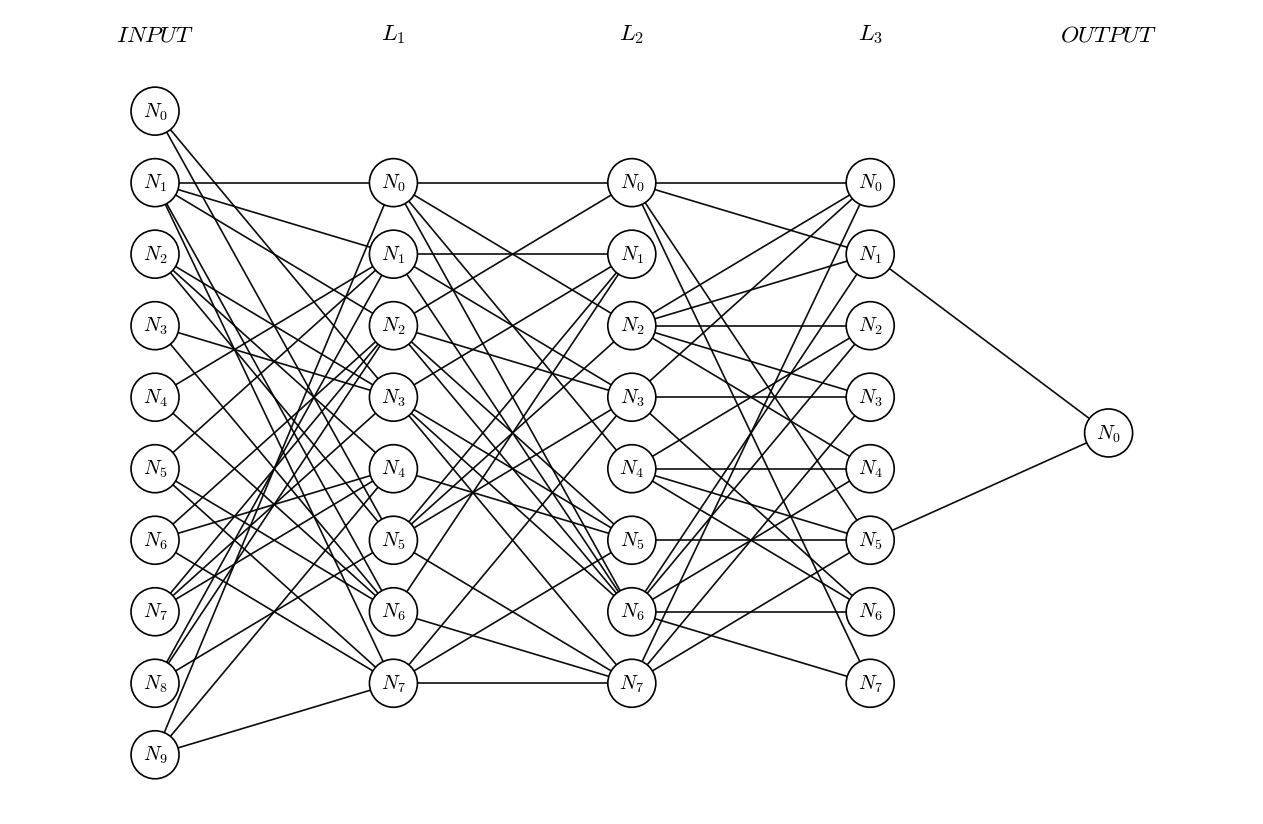

In [66]:
desc = describe_architecture(net)
plot_architecture_networkx(
    desc,
    layer_separation=3,
    node_separation=0.9,
    header_font_size = 14.0,
    edge_width=1,
)

In [32]:
def reduce_ripper_net(net) -> "DeepBinaryClassifier":
    for layer in net.layers:
        for node in layer:
            if hasattr(node, "reduce_expression"):
                node.reduce_expression()
    return net


red_net = reduce_ripper_net(net)
red_net.prune()

pred_test_after = red_net.predict(X_test)

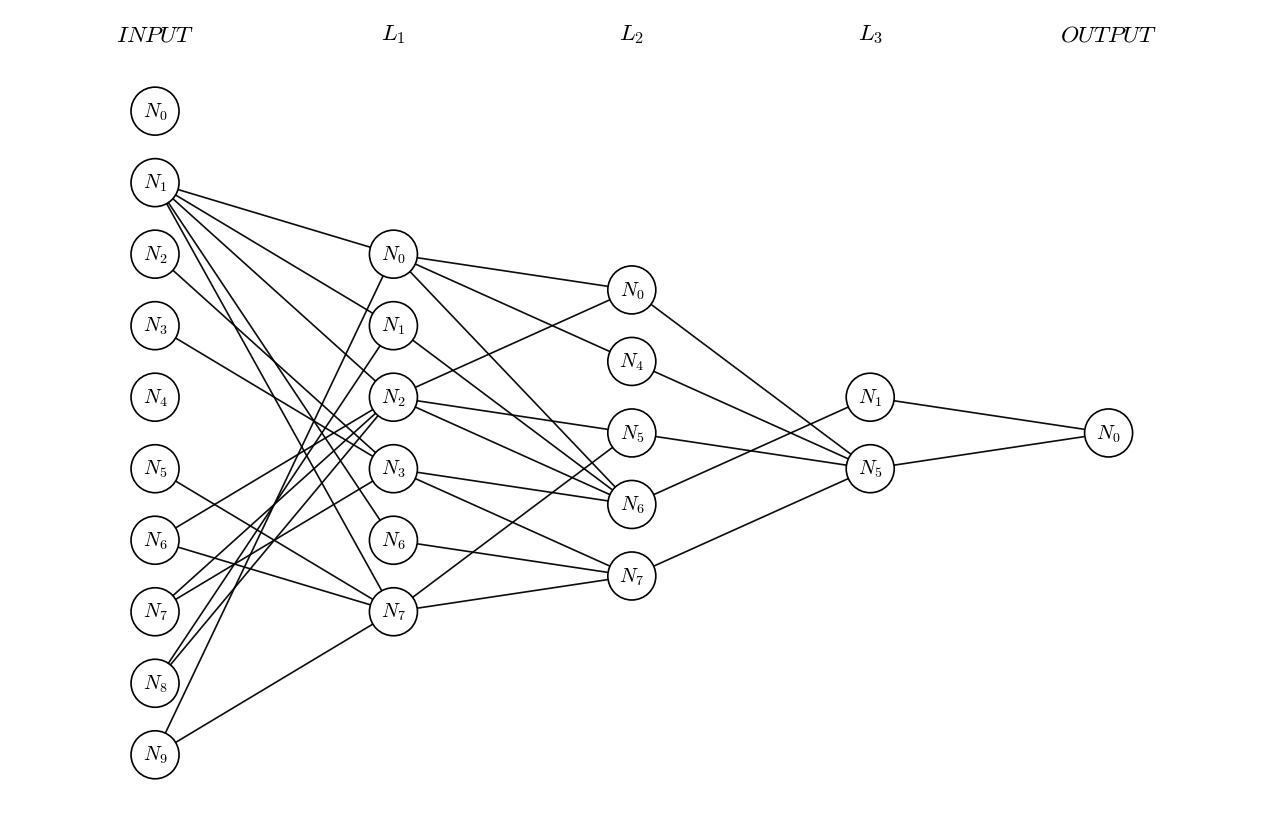

In [67]:
desc_after = describe_architecture(red_net)

plot_architecture_networkx(
    desc_after,
    layer_separation=3,
    node_separation=0.9,
    header_font_size = 14.0,
    edge_width=1,
)